In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor

Setam un seed arbirtrat pentru reproducerea experimentului

In [22]:
np.random.seed(42)

Cream o imagine originala

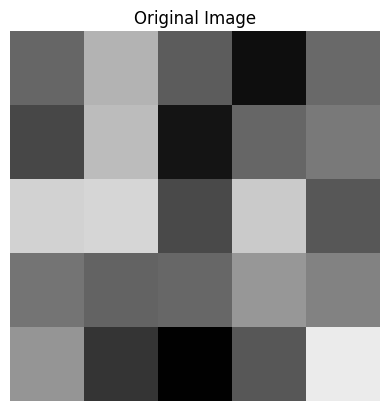

In [23]:
original_image = np.random.randint(0, 256, size=(5, 5)) # genereaza o matrice de 5x5 cu valori intregi aleatorii intre 0 si 255
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255) # se afiseaza imaginea cu nuante de gri, cu intensitatea pixelilor intre 0 si 255
plt.title('Original Image')
plt.axis('off') # nu se afiseaza valorile de pe margini
plt.show() # afisarea efectiva a imaginii

Se adauga "zgomot" imaginii

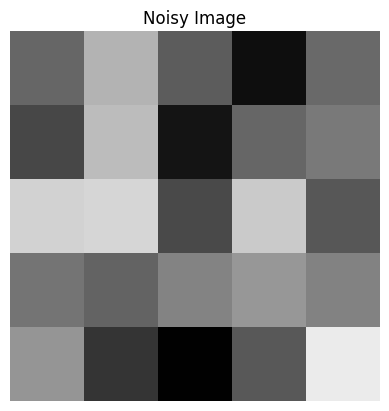

In [24]:
noisy_image = original_image.copy()
num_noisy_pixels = int(0.1 * original_image.size) # 10% din pixeli vor fi afectati
noisy_indices = np.unravel_index(
    np.random.choice(original_image.size, num_noisy_pixels, replace=False), # se aleg random pixeli care vor fi afectati de zgomot
    original_image.shape
)
noisy_image[noisy_indices] = np.random.randint(0, 256, size=num_noisy_pixels)
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.title('Noisy Image')
plt.axis('off')
plt.show()

Crearea retelei Markov

In [25]:
model = MarkovNetwork()
pixels = [(i, j) for i in range(5) for j in range(5)]
model.add_nodes_from(pixels)
edges = []
for i in range(5):
    for j in range(5):
        if i < 4:
            edges.append(((i, j), (i+1, j)))
        if j < 4:
            edges.append(((i, j), (i, j+1)))
model.add_edges_from(edges)

Discretizarea si restaurarea valorilor pixelilor

In [26]:
num_levels = 8 # niveluri discrete
_lambda = 0.8 # parametru de regularizare

def discretize(value): # transofrma o valoare din 0-255 in 0-8
    return int(value * (num_levels - 1) / 255)

def undiscretize(level):
    return int(level * 255 / (num_levels - 1))

discretized_image = np.vectorize(discretize)(noisy_image) # se aplica functia 

Pregatirea factorilor unari pentru modelul Markov pentru inferenta

In [27]:
unary_factors = {}
for i in range(5):
    for j in range(5):
        observed_value = discretized_image[i, j] # extrage valoarea discretizata 
        variable = (i, j)
        states = np.arange(num_levels) # creaza un vector care contine toate starile posibile ale pixelului (0-8)
        potential = np.exp(-_lambda * (states - observed_value) ** 2) # calculeaza potentialul unar pentru fiecare stare posibila
        unary_factors[variable] = potential / potential.sum() # normalizare a.i suma tuturor valorilor din potential sa fie 1


Pregatirea potentialelor perechi 

In [28]:
states = np.arange(num_levels) # se creeaza un vector ce contine toate starile
pairwise_potential = np.exp(- (np.subtract.outer(states, states)) ** 2) # se creeaza o matrice de potentiale perechi, facand ca valorile sa fie similare
pairwise_potential /= pairwise_potential.sum(axis=1, keepdims=True) # normalizare astfel incat suma sa fie 1
current_image = discretized_image.copy() 

Algoritmul ICM (Iterated Conditional Modes)

In [29]:
def icm_iteration(image, unary_factors, pairwise_potential): # functie care realizeaza o iteratie a ICM
    new_image = image.copy()
    for i in range(5):
        for j in range(5):
            variable = (i, j)
            best_state = None # pastreaza starea care minimizeaza energia pentru pixelul curent
            best_energy = np.inf # pastreaza cea mai mica energie gasita pana acum

            # se testeaza fiecare stare posibila pentru pixel
            for state in range(num_levels):
                # se calculeaza energia asociata cu starea state
                energy = -np.log(unary_factors[variable][state])

                # se adauga energiile pereche de la vecini
                for neighbor in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                    if 0 <= neighbor[0] < 5 and 0 <= neighbor[1] < 5:
                        neighbor_state = image[neighbor]
                        energy += -np.log(pairwise_potential[state, neighbor_state])

                # se actualizeaza daca aceasta stare are energia mai mica
                if energy < best_energy:
                    best_energy = energy
                    best_state = state

            new_image[i, j] = best_state # se adauga cea mai buna stare
    return new_image

Executa algoritmul de 10 ori si reconstruieste imaginea

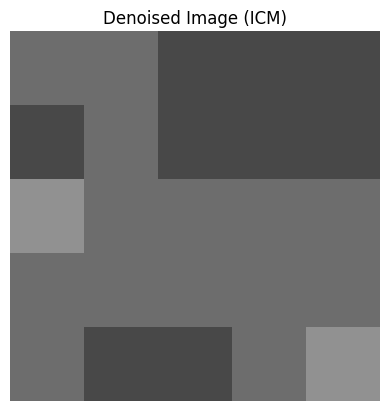

In [30]:

num_iterations = 10

for _ in range(num_iterations):
    current_image = icm_iteration(current_image, unary_factors, pairwise_potential)

denoised_image = np.vectorize(undiscretize)(current_image)

plt.imshow(denoised_image, cmap='gray', vmin=0, vmax=255)
plt.title('Denoised Image (ICM)')
plt.axis('off')
plt.show()